# Bayesian Changepoint Detection in Python
This code computes the probability of changepoints in a time series.7 In this notebook I show how you can use it.

First let's generate some data:

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn
from __future__ import division

%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
def generate_normal_time_series(num, minl=50, maxl=1000):
    data = np.array([], dtype=np.float64)
    partition = np.random.randint(minl, maxl, num)
    for p in partition:
        mean = np.random.randn()*10
        var = np.random.randn()*1
        if var < 0:
            var = var * -1
        tdata = np.random.normal(mean, var, p)
        data = np.concatenate((data, tdata))
    return data

In [13]:
data = generate_normal_time_series(7, 50, 200)

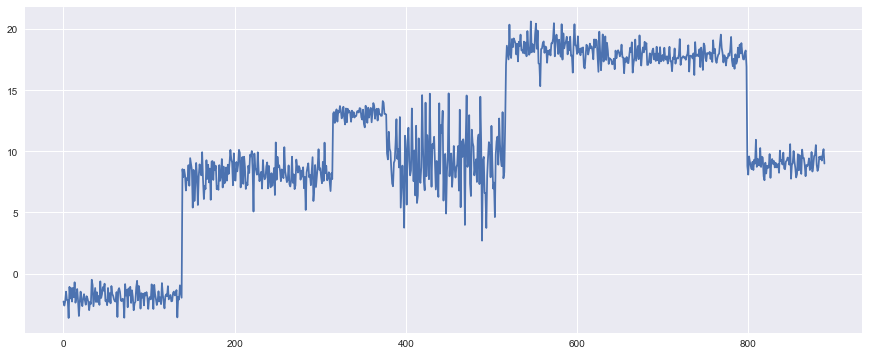

In [14]:
fig, ax = plt.subplots(figsize=[15, 6])
ax.plot(data)

## Offline Changepoint Detection
Lets compute the probability of changepoints at each time step. We need two things for that. First a prior of how probable is it to have two successive changepoints with the distance t. The second thing is a model of the likelihood of data in a sequence [s, t] of the data, given that in this sequence there is no changepoint.

For this example we assume a uniform prior over the length of sequences (const_prior) and a piecewise gaussian model (gaussian_obs_log_likelihood).

In [15]:
import cProfile

In [16]:
#import bayesian_changepoint_detection.offline_changepoint_detection as offcd
from functools import partial

In [17]:
from __future__ import division
import numpy as np
from scipy.special import gammaln, multigammaln
from scipy.misc import comb
from decorator import decorator

# This makes the code compatible with Python 3
# without causing performance hits on Python 2
try:
    xrange
except NameError:
    xrange = range


try:
    from sselogsumexp import logsumexp
except ImportError:
    from scipy.misc import logsumexp
    print("Use scipy logsumexp().")
else:
    print("Use SSE accelerated logsumexp().")


def _dynamic_programming(f, *args, **kwargs):
    if f.data is None:
        f.data = args[0]

    if not np.array_equal(f.data, args[0]):
        f.cache = {}
        f.data = args[0]

    try:
        f.cache[args[1:3]]
    except KeyError:
        f.cache[args[1:3]] = f(*args, **kwargs)
    return f.cache[args[1:3]]

def dynamic_programming(f):
    f.cache = {}
    f.data = None
    return decorator(_dynamic_programming, f)


def offline_changepoint_detection(data, prior_func,
                                  observation_log_likelihood_function,
                                  truncate=-np.inf):
    """Compute the likelihood of changepoints on data.
    Keyword arguments:
    data                                -- the time series data
    prior_func                          -- a function giving the likelihood of a changepoint given the distance to the last one
    observation_log_likelihood_function -- a function giving the log likelihood
                                           of a data part
    truncate                            -- the cutoff probability 10^truncate to stop computation for that changepoint log likelihood
    P                                   -- the likelihoods if pre-computed
    """

    n = len(data)
    Q = np.zeros((n,))
    g = np.zeros((n,))
    G = np.zeros((n,))
    P = np.ones((n, n)) * -np.inf

    # save everything in log representation
    for t in range(n):
        g[t] = np.log(prior_func(t))
        if t == 0:
            G[t] = g[t]
        else:
            '''Logarithm of the sum of exponentiations of the inputs.

            Calculates ``log(exp(x1) + exp(x2))``. This function is useful in
            statistics where the calculated probabilities of events may be so small
            as to exceed the range of normal floating point numbers.  In such cases
            the logarithm of the calculated probability is stored. This function
            allows adding probabilities stored in such a fashion.'''
            G[t] = np.logaddexp(G[t-1], g[t])

    P[n-1, n-1] = observation_log_likelihood_function(data, n-1, n)
    Q[n-1] = P[n-1, n-1]

    for t in reversed(range(n-1)):
        P_next_cp = -np.inf  # == log(0)
        for s in range(t, n-1):
            P[t, s] = observation_log_likelihood_function(data, t, s+1)

            # compute recursion
            summand = P[t, s] + Q[s + 1] + g[s + 1 - t]
            P_next_cp = np.logaddexp(P_next_cp, summand)

            # truncate sum to become approx. linear in time (see
            # Fearnhead, 2006, eq. (3))
            if summand - P_next_cp < truncate:
                break

        P[t, n-1] = observation_log_likelihood_function(data, t, n)

        # (1 - G) is numerical stable until G becomes numerically 1
        if G[n-1-t] < -1e-15:  # exp(-1e-15) = .99999...
            antiG = np.log(1 - np.exp(G[n-1-t]))
        else:
            # (1 - G) is approx. -log(G) for G close to 1
            antiG = np.log(-G[n-1-t])

        Q[t] = np.logaddexp(P_next_cp, P[t, n-1] + antiG)

    Pcp = np.ones((n-1, n-1)) * -np.inf
    for t in range(n-1):
        Pcp[0, t] = P[0, t] + Q[t + 1] + g[t] - Q[0]
        if np.isnan(Pcp[0, t]):
            Pcp[0, t] = -np.inf
    for j in range(1, n-1):
        for t in range(j, n-1):
            tmp_cond = Pcp[j-1, j-1:t] + P[j:t+1, t] + Q[t + 1] + g[0:t-j+1] - Q[j:t+1]
            Pcp[j, t] = logsumexp(tmp_cond.astype(np.float32))
            if np.isnan(Pcp[j, t]):
                Pcp[j, t] = -np.inf

    return Q, P, Pcp

@dynamic_programming
def gaussian_obs_log_likelihood(data, t, s):
    s += 1
    n = s - t
    mean = data[t:s].sum(0) / n

    muT = (n * mean) / (1 + n)
    nuT = 1 + n
    alphaT = 1 + n / 2
    betaT = 1 + 0.5 * ((data[t:s] - mean) ** 2).sum(0) + ((n)/(1 + n)) * (mean**2 / 2)
    scale = (betaT*(nuT + 1))/(alphaT * nuT)

    # splitting the PDF of the student distribution up is /much/ faster.
    # (~ factor 20) using sum over for loop is even more worthwhile
    prob = np.sum(np.log(1 + (data[t:s] - muT)**2/(nuT * scale)))
    lgA = gammaln((nuT + 1) / 2) - np.log(np.sqrt(np.pi * nuT * scale)) - gammaln(nuT/2)

    return np.sum(n * lgA - (nuT + 1)/2 * prob)

def ifm_obs_log_likelihood(data, t, s):
    '''Independent Features model from xuan et al'''
    s += 1
    n = s - t
    x = data[t:s]
    if len(x.shape)==2:
        d = x.shape[1]
    else:
        d = 1
        x = np.atleast_2d(x).T

    N0 = d          # weakest prior we can use to retain proper prior
    V0 = np.var(x)
    Vn = V0 + (x**2).sum(0)

    # sum over dimension and return (section 3.1 from Xuan paper):
    return d*( -(n/2)*np.log(np.pi) + (N0/2)*np.log(V0) - \
        gammaln(N0/2) + gammaln((N0+n)/2) ) - \
        ( ((N0+n)/2)*np.log(Vn) ).sum(0)

def fullcov_obs_log_likelihood(data, t, s):
    '''Full Covariance model from xuan et al'''
    s += 1
    n = s - t
    x = data[t:s]
    if len(x.shape)==2:
        dim = x.shape[1]
    else:
        dim = 1
        x = np.atleast_2d(x).T

    N0 = dim          # weakest prior we can use to retain proper prior
    V0 = np.var(x)*np.eye(dim)
    
    # Improvement over np.outer
    # http://stackoverflow.com/questions/17437523/python-fast-way-to-sum-outer-products
    # Vn = V0 + np.array([np.outer(x[i], x[i].T) for i in xrange(x.shape[0])]).sum(0)
    Vn = V0 + np.einsum('ij,ik->jk', x, x)

    # section 3.2 from Xuan paper:
    return -(dim*n/2)*np.log(np.pi) + (N0/2)*np.linalg.slogdet(V0)[1] - \
        multigammaln(N0/2,dim) + multigammaln((N0+n)/2,dim) - \
        ((N0+n)/2)*np.linalg.slogdet(Vn)[1]

def const_prior(r, l):
    return 1/(l)

def geometric_prior(t, p):
    return p * ((1 - p) ** (t - 1))

def neg_binominal_prior(t, k, p):
    return comb(t - k, k - 1) * p ** k * (1 - p) ** (t - k)

Use scipy logsumexp().


In [13]:
Q, P, Pcp = offline_changepoint_detection(data, partial(const_prior, l=(len(data)+1)), gaussian_obs_log_likelihood, truncate=-40)

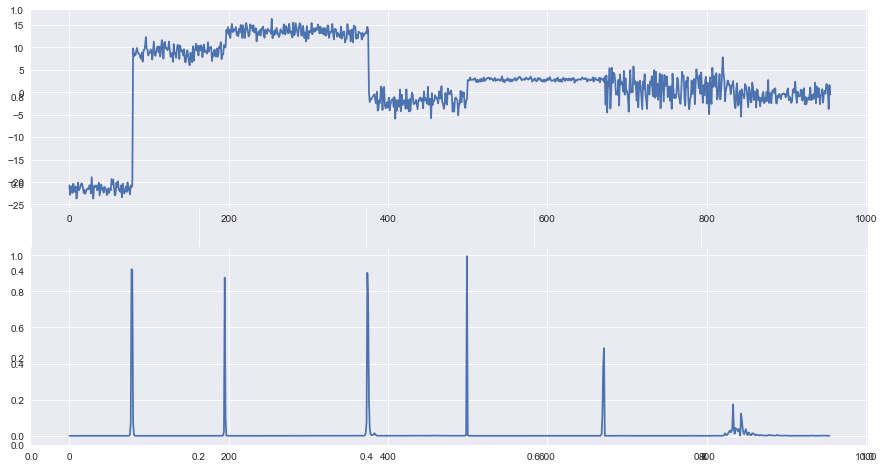

In [16]:
fig, ax = plt.subplots(figsize=[15, 8])
ax = fig.add_subplot(2, 1, 1)
ax.plot(data[:])
ax = fig.add_subplot(2, 1, 2, sharex=ax)
ax.plot(np.exp(Pcp).sum(0))

That works pretty well, but is somewhat slow. It's possible to speed that up by truncating a sum in the algorithm. However that sometimes leeds to ∞ values. Set the truncate parameter to e.g. -10 to test that out.

To understand, what is happening have a look at the following papers:

[1] Paul Fearnhead, Exact and Efficient Bayesian Inference for Multiple Changepoint problems, Statistics and computing 16.2 (2006), pp. 203--213

[2] Xuan Xiang, Kevin Murphy, Modeling Changing Dependency Structure in Multivariate Time Series, ICML (2007), pp. 1055--1062

## Online Changepoint Detection

Let's assume the data points come in one after another and not as these nice batches. During the process you want to know if the new point has the same hyperparameter or different ones. You need an online changepoint detection.

Happily there is one, although it's interface is kind of suboptimal so far, in that it expects batches of data still and just assumes they drop in over time... I will change that at some point.

In [18]:
from __future__ import division
import numpy as np
from scipy import stats

def online_changepoint_detection(data, hazard_func, observation_likelihood):
    maxes = np.zeros(len(data) + 1)
    
    R = np.zeros((len(data) + 1, len(data) + 1))
    R[0, 0] = 1
    
    for t, x in enumerate(data):
        # Evaluate the predictive distribution for the new datum under each of
        # the parameters.  This is the standard thing from Bayesian inference.
        predprobs = observation_likelihood.pdf(x)
        
        # Evaluate the hazard function for this interval
        H = hazard_func(np.array(range(t+1)))
       
        # Evaluate the growth probabilities - shift the probabilities down and to
        # the right, scaled by the hazard function and the predictive
        # probabilities.
        R[1:t+2, t+1] = R[0:t+1, t] * predprobs * (1-H)
        
        # Evaluate the probability that there *was* a changepoint and we're
        # accumulating the mass back down at r = 0.
        R[0, t+1] = np.sum( R[0:t+1, t] * predprobs * H)
        
        # Renormalize the run length probabilities for improved numerical
        # stability.
        R[:, t+1] = R[:, t+1] / np.sum(R[:, t+1])
        
        # Update the parameter sets for each possible run length.
        observation_likelihood.update_theta(x)
    
        maxes[t] = R[:, t].argmax()
    return R, maxes


def constant_hazard(lam, r):
    return 1/lam * np.ones(r.shape)


class StudentT:
    def __init__(self, alpha, beta, kappa, mu):
        self.alpha0 = self.alpha = np.array([alpha])
        self.beta0 = self.beta = np.array([beta])
        self.kappa0 = self.kappa = np.array([kappa])
        self.mu0 = self.mu = np.array([mu])

    def pdf(self, data):
        return stats.t.pdf(x=data, 
                           df=2*self.alpha,
                           loc=self.mu,
                           scale=np.sqrt(self.beta * (self.kappa+1) / (self.alpha *
                               self.kappa)))

    def update_theta(self, data):
        muT0 = np.concatenate((self.mu0, (self.kappa * self.mu + data) / (self.kappa + 1)))
        kappaT0 = np.concatenate((self.kappa0, self.kappa + 1.))
        alphaT0 = np.concatenate((self.alpha0, self.alpha + 0.5))
        betaT0 = np.concatenate((self.beta0, self.beta + (self.kappa * (data -
            self.mu)**2) / (2. * (self.kappa + 1.))))
            
        self.mu = muT0
        self.kappa = kappaT0
        self.alpha = alphaT0
        self.beta = betaT0

In [19]:
R, maxes = online_changepoint_detection(data, partial(constant_hazard, 250), StudentT(0.1, .01, 1, 0))

The online version computes slightly different things. For each time step it returns the probability distribution over the length of the last sequence. E.g. R[7, 3] is the probability at time step 7 that the last sequence is already 3 time steps long. It also returns the MAP estimate at each timestep for convenience.

To plot the distributions we use a grey-scale colormap, black is zero, white 1. We also plot the probability at each time step for a sequence length of 0, i.e. the probability of the current time step to be a changepoint.

Because it's very hard to correctly evaluate a change after a single sample of a new distribution, we instead can "wait" for Nw samples and evalute the probability of a change happening Nw samples prior.

/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:9: RuntimeWarning: divide by zero encountered in log


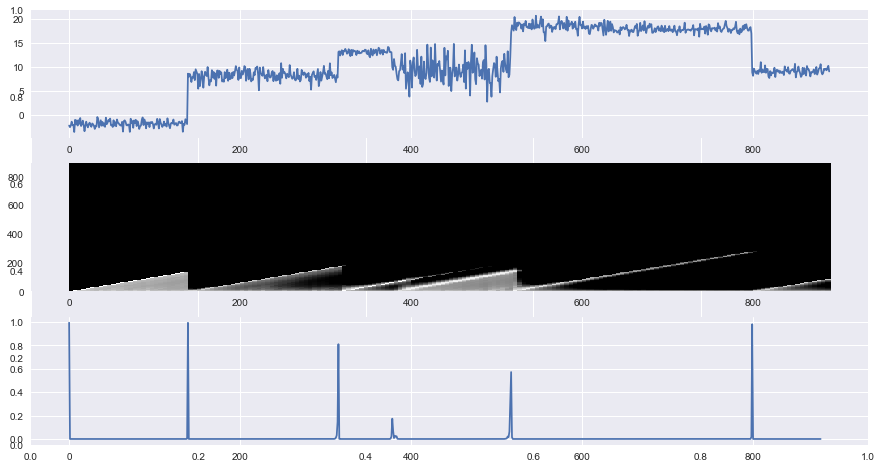

In [20]:
import matplotlib.cm as cm
fig, ax = plt.subplots(figsize=[15, 8])
ax = fig.add_subplot(3, 1, 1)
ax.plot(data)
ax = fig.add_subplot(3, 1, 2, sharex=ax)
sparsity = 5  # only plot every fifth data for faster display
ax.pcolor(np.array(range(0, len(R[:,0]), sparsity)), 
          np.array(range(0, len(R[:,0]), sparsity)), 
          -np.log(R[0:-1:sparsity, 0:-1:sparsity]), 
          cmap=cm.Greys, vmin=0, vmax=30)
ax = fig.add_subplot(3, 1, 3, sharex=ax)
Nw=10;
ax.plot(R[Nw,Nw:-1])

Well, not bad, considering how much faster it is (if you can afford waiting for that extra Nw samples). To understand the whole algorithm look at

[1] Ryan P. Adams, David J.C. MacKay, Bayesian Online Changepoint Detection, arXiv 0710.3742 (2007)

There you also find a Matlab version, which this code is based on.

# Bayesian Changepoint Detection with multivariate data
This code computes the probability of changepoints (including changes in correlation) in a time series. In this notebook I show how you can use it. This example is modified from Xiang Xuan's thesis Section 3.2.

First let's generate some data and load some modules:

In [23]:
from __future__ import division
import matplotlib.pyplot as plt
#import bayesian_changepoint_detection.generate_data as gd
import seaborn

%matplotlib inline
#%load_ext autoreload
#%autoreload 2

partition, data = generate_xuan_motivating_example(200,500)

In [30]:
print(partition)
print(data.shape)

[214 429 354]
(997, 2)


In [41]:
print(data[0:5].shape)
print(data[0:5])
print(data[0:5].sum(0))
print(data[0:5].sum(1))
print('data is a', type(data))

(5, 2)
[[-0.16663615 -0.27594471]
 [ 2.18477375  1.58394958]
 [-0.64207363 -0.50673904]
 [ 0.48988027  0.32239378]
 [ 0.04354404  0.62740249]]
[ 1.90948828  1.7510621 ]
[-0.44258086  3.76872334 -1.14881267  0.81227406  0.67094653]
data is a <class 'numpy.ndarray'>


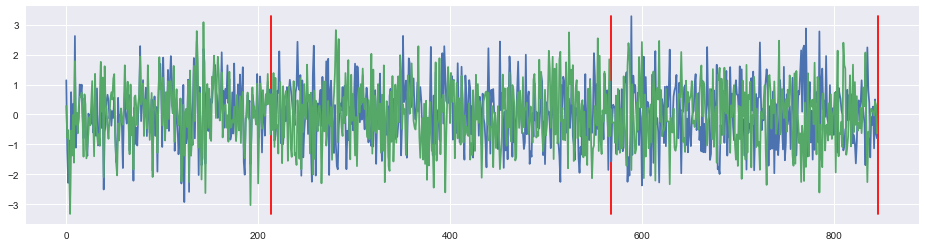

In [22]:
changes = np.cumsum(partition)

fig, ax = plt.subplots(figsize=[16, 4])
for p in changes:
  ax.plot([p,p],[np.min(data),np.max(data)],'r')
for d in range(2):
  ax.plot(data[:,d])

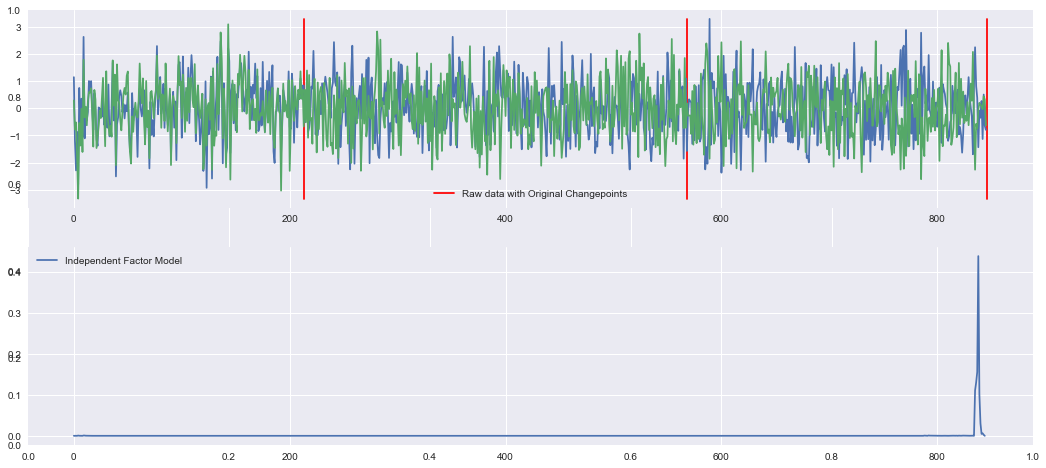

In [23]:
from functools import partial

Q_ifm, P_ifm, Pcp_ifm = offline_changepoint_detection(data,partial(const_prior, l=(len(data)+1)),ifm_obs_log_likelihood,truncate=-20)

fig, ax = plt.subplots(figsize=[18, 8])
ax = fig.add_subplot(2, 1, 1)
for p in changes:
  ax.plot([p,p],[np.min(data),np.max(data)],'r')
for d in range(2):
  ax.plot(data[:,d])
plt.legend(['Raw data with Original Changepoints'])
ax = fig.add_subplot(2, 1, 2, sharex=ax)
ax.plot(np.exp(Pcp_ifm).sum(0))
plt.legend(['Independent Factor Model'])
plt.show()

Unfortunately, not very good... Now let's try the full covariance model (warning, it'll take a while):

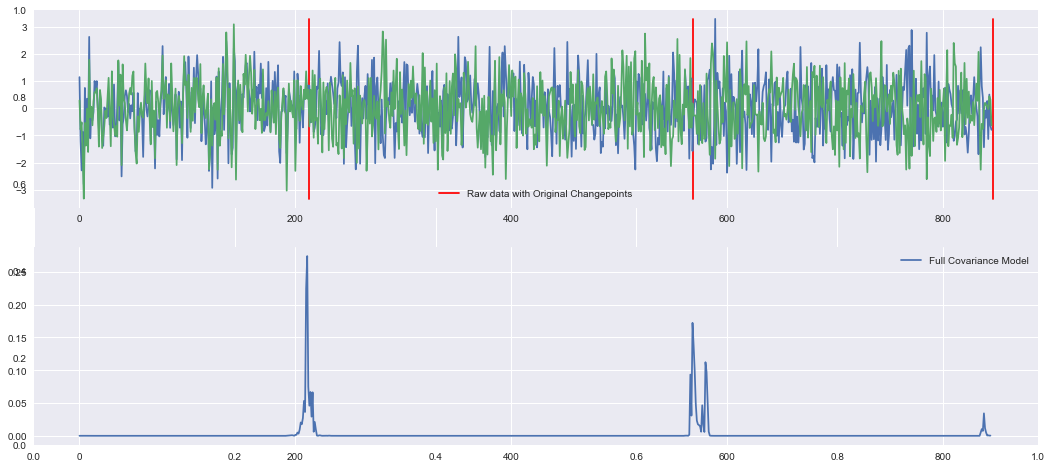

In [24]:
Q_full, P_full, Pcp_full = offline_changepoint_detection(data,partial(const_prior, l=(len(data)+1)),fullcov_obs_log_likelihood, truncate=-20)

fig, ax = plt.subplots(figsize=[18, 8])
ax = fig.add_subplot(2, 1, 1)
for p in changes:
  ax.plot([p,p],[np.min(data),np.max(data)],'r')
for d in range(2):
  ax.plot(data[:,d])
plt.legend(['Raw data with Original Changepoints'])
ax = fig.add_subplot(2, 1, 2, sharex=ax)
ax.plot(np.exp(Pcp_full).sum(0))
plt.legend(['Full Covariance Model'])
plt.show()

Much better now

In [22]:
from __future__ import division
import numpy as np

def generate_normal_time_series(num, minl=50, maxl=1000):
  data = np.array([], dtype=np.float64)
  partition = np.random.randint(minl, maxl, num)
  for p in partition:
    mean = np.random.randn()*10
    var = np.random.randn()*1
    if var < 0:
      var = var * -1
    tdata = np.random.normal(mean, var, p)
    data = np.concatenate((data, tdata))
  return partition, np.atleast_2d(data).T

def generate_multinormal_time_series(num, dim, minl=50, maxl=1000):
  data = np.empty((1,dim), dtype=np.float64)
  partition = np.random.randint(minl, maxl, num)
  for p in partition:
    mean = np.random.standard_normal(dim)*10
    # Generate a random SPD matrix
    A = np.random.standard_normal((dim,dim))
    var = np.dot(A,A.T)

    tdata = np.random.multivariate_normal(mean, var, p)
    data = np.concatenate((data, tdata))
  return partition, data[1:,:]

def generate_xuan_motivating_example(minl=50, maxl=1000):
  dim = 2
  num = 3
  partition = np.random.randint(minl, maxl, num)
  mu = np.zeros(dim)
  Sigma1 = np.asarray([[1.0,0.75],[0.75,1.0]])
  data = np.random.multivariate_normal(mu, Sigma1, partition[0])
  Sigma2 = np.asarray([[1.0,0.0],[0.0,1.0]])
  data = np.concatenate((data,np.random.multivariate_normal(mu, Sigma2, partition[1])))
  Sigma3 = np.asarray([[1.0,-0.75],[-0.75,1.0]])
  data = np.concatenate((data,np.random.multivariate_normal(mu, Sigma3, partition[2])))
  return partition, data